In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.distributions.empirical_distribution import ECDF
from datetime import datetime as dt


warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# Train Dataset
train_df = pd.read_csv("./data/train.csv", parse_dates=True, low_memory=False, index_col='Date')

# Store Data
store_df = pd.read_csv("./data/store.csv", low_memory=False)

# Test Dataset
test_df = pd.read_csv("./data/test.csv", parse_dates=True, low_memory=False, index_col='Date')

# Sample Submission
sample_df = pd.read_csv("./data/sample_submission.csv")


In [4]:
train_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [5]:
train_df.shape

(1017209, 8)

In [6]:
train_df.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01'], dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [8]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
test_df.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


In [10]:
sample_df.head()

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [11]:
# Data Extraction
train_df['Year'] = train_df.index.year
train_df['Month'] = train_df.index.month
train_df['Day'] = train_df.index.day
train_df['DayName'] = train_df.index.day_name()
train_df['WkofYr'] = train_df.index.weekofyear
train_df['DayofYr'] = train_df.index.day_of_year
train_df['DayofWk'] = train_df.index.day_of_week
train_df.tail(10)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,DayName,WkofYr,DayofYr,DayofWk
Date,,,,,,,,,,,,,,,
2013-01-01,1106,2,0,0,0,0,a,1,2013,1,1,Tuesday,1,1,1
2013-01-01,1107,2,0,0,0,0,a,1,2013,1,1,Tuesday,1,1,1
2013-01-01,1108,2,0,0,0,0,a,1,2013,1,1,Tuesday,1,1,1
2013-01-01,1109,2,0,0,0,0,a,1,2013,1,1,Tuesday,1,1,1
2013-01-01,1110,2,0,0,0,0,a,1,2013,1,1,Tuesday,1,1,1
2013-01-01,1111,2,0,0,0,0,a,1,2013,1,1,Tuesday,1,1,1
2013-01-01,1112,2,0,0,0,0,a,1,2013,1,1,Tuesday,1,1,1
2013-01-01,1113,2,0,0,0,0,a,1,2013,1,1,Tuesday,1,1,1
2013-01-01,1114,2,0,0,0,0,a,1,2013,1,1,Tuesday,1,1,1


In [12]:
train_df['SalesPerCustomer'] = train_df.Sales/train_df.Customers
train_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,DayName,WkofYr,DayofYr,DayofWk,SalesPerCustomer
Date,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,Friday,31,212,4,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,Friday,31,212,4,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,Friday,31,212,4,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,Friday,31,212,4,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,Friday,31,212,4,8.626118


In [13]:
train_df['SalesPerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

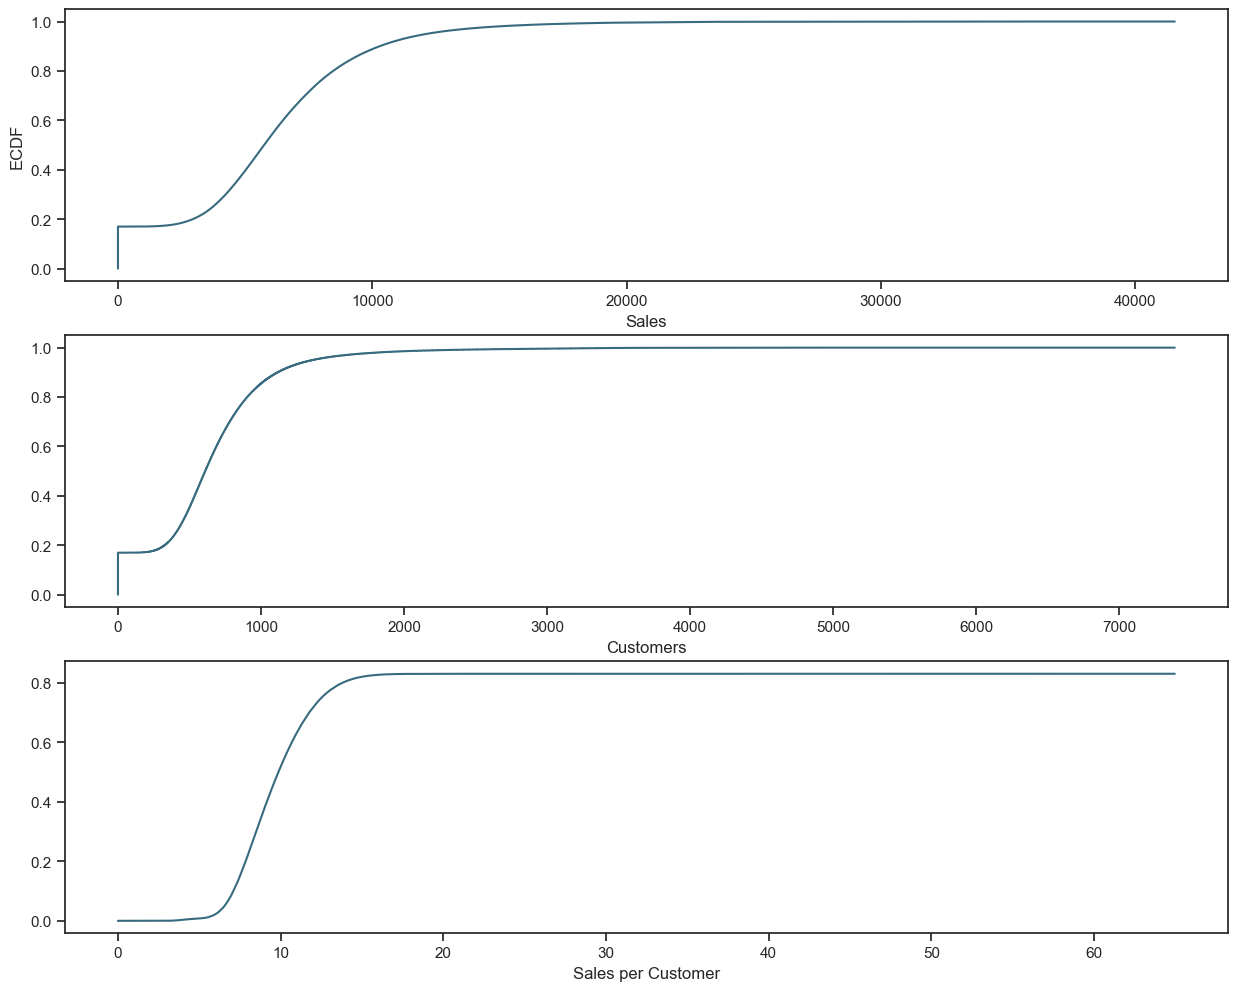

In [14]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (15, 12))

plt.subplot(311)
cdf = ECDF(train_df['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train_df['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train_df['SalesPerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales per Customer');

##### About 20% of data has zero amount of sales / customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000

### Missing Values
---

In [15]:
# closed stores and stores with no sales
train_df[(train_df.Open == 0)&(train_df.Sales == 0)]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,DayName,WkofYr,DayofYr,DayofWk,SalesPerCustomer
Date,,,,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,Friday,31,212,4,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,Friday,31,212,4,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,Thursday,31,211,3,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,Thursday,31,211,3,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,Wednesday,31,210,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,0,a,1,2013,1,1,Tuesday,1,1,1,NaN
2013-01-01,1112,2,0,0,0,0,a,1,2013,1,1,Tuesday,1,1,1,NaN
2013-01-01,1113,2,0,0,0,0,a,1,2013,1,1,Tuesday,1,1,1,NaN


In [16]:
len(train_df[(train_df.Open == 0)&(train_df.Sales == 0)])

172817

In [17]:
print("There are %d closed stores in the training dataset."%len(train_df[train_df.Open == 0]))
print("%f percent of the stores in the training dataset are closed"%(len(train_df[train_df.Open == 0])/len(train_df)*100))

There are 172817 closed stores in the training dataset.
16.989331 percent of the stores in the training dataset are closed


In [18]:
print("Around %f percent of the stores in the training dataset are closed"%(len(train_df[train_df.Open == 0])/len(train_df)*100))

Around 16.989331 percent of the stores in the training dataset are closed


In [19]:
len(train_df[train_df.Sales == 0])

172871

In [20]:
# opened stores with zero sales
zero_sales = train_df[(train_df.Open == 1) & (train_df.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head()

In total:  (54, 16)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,DayName,WkofYr,DayofYr,DayofWk,SalesPerCustomer
Date,,,,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,Friday,20,135,4,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,Thursday,13,85,3,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,Thursday,6,36,3,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,Wednesday,40,274,2,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,Monday,39,265,0,NaN


In [21]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train_df = train_df[(train_df["Open"] != 0) & (train_df['Sales'] != 0)]

print("In total: ", train_df.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 16)


In [22]:
# additional information about the stores
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [23]:
# missing value
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [24]:
# missing values in competition distance
store_df[pd.isnull(store_df.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [25]:
# fill NaN with a median value (skewed distribuion)
store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median(), inplace = True)

In [26]:
# no promo = no information about the promo?
_ = store_df[pd.isnull(store_df.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

##### If there's no Promo2 then there's no information about it. We can replace these values by zeros. The same goes for tha variables deducted from the competition

In [27]:
# replace NA's by 0
store_df.fillna(0, inplace = True)

In [28]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store_df = pd.merge(train_df, store_df, how = 'inner', on = 'Store')

print("In total: ", train_store_df.shape)
train_store_df.head()

Joining train set with an additional store information.
In total:  (844338, 25)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,DayName,WkofYr,DayofYr,DayofWk,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,31,Friday,31,212,4,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,30,Thursday,31,211,3,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,29,Wednesday,31,210,2,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,28,Tuesday,31,209,1,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,27,Monday,31,208,0,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### Store Types
---

In [29]:
train_store_df.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


##### StoreType B has the highest average of Sales among all others, however we have much less data for it. So let's print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one

In [30]:
train_store_df.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


<Figure size 900x600 with 0 Axes>

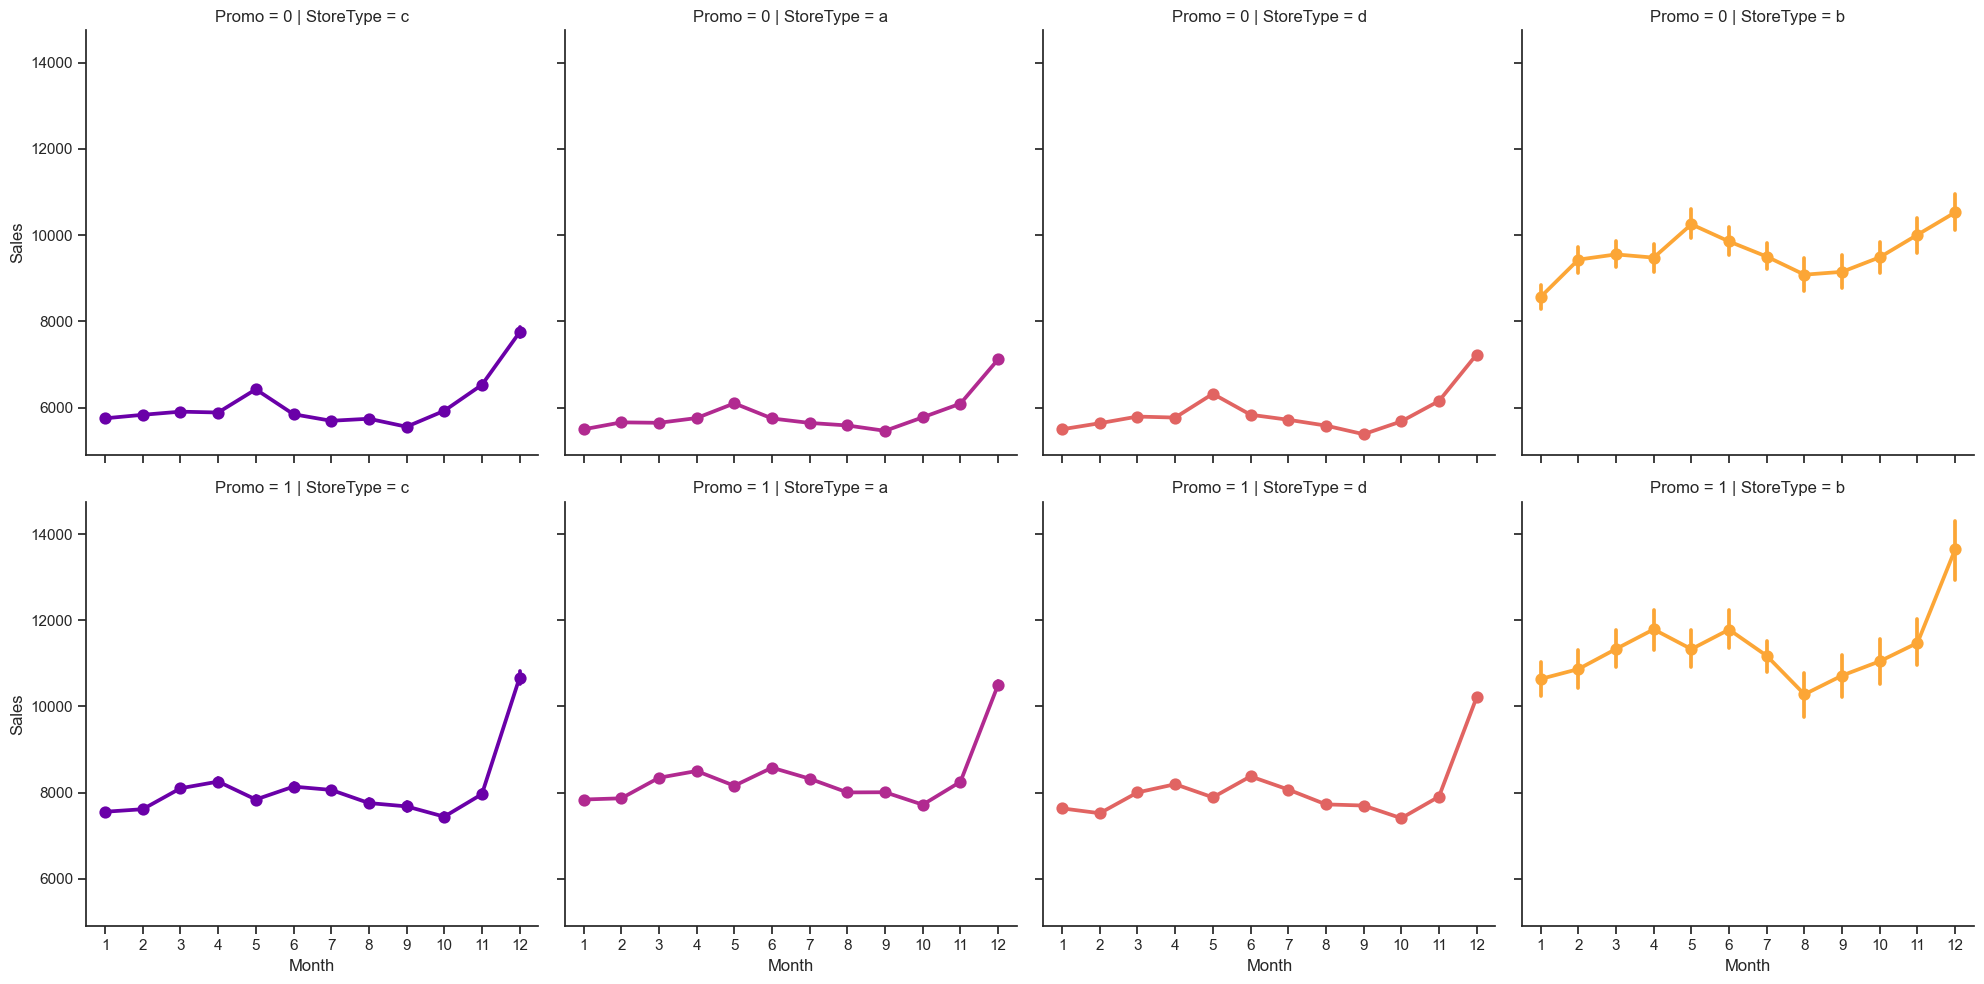

In [31]:
# sales trends
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (9, 6))

sns.catplot(data = train_store_df, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               kind = 'point',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 
plt.show()

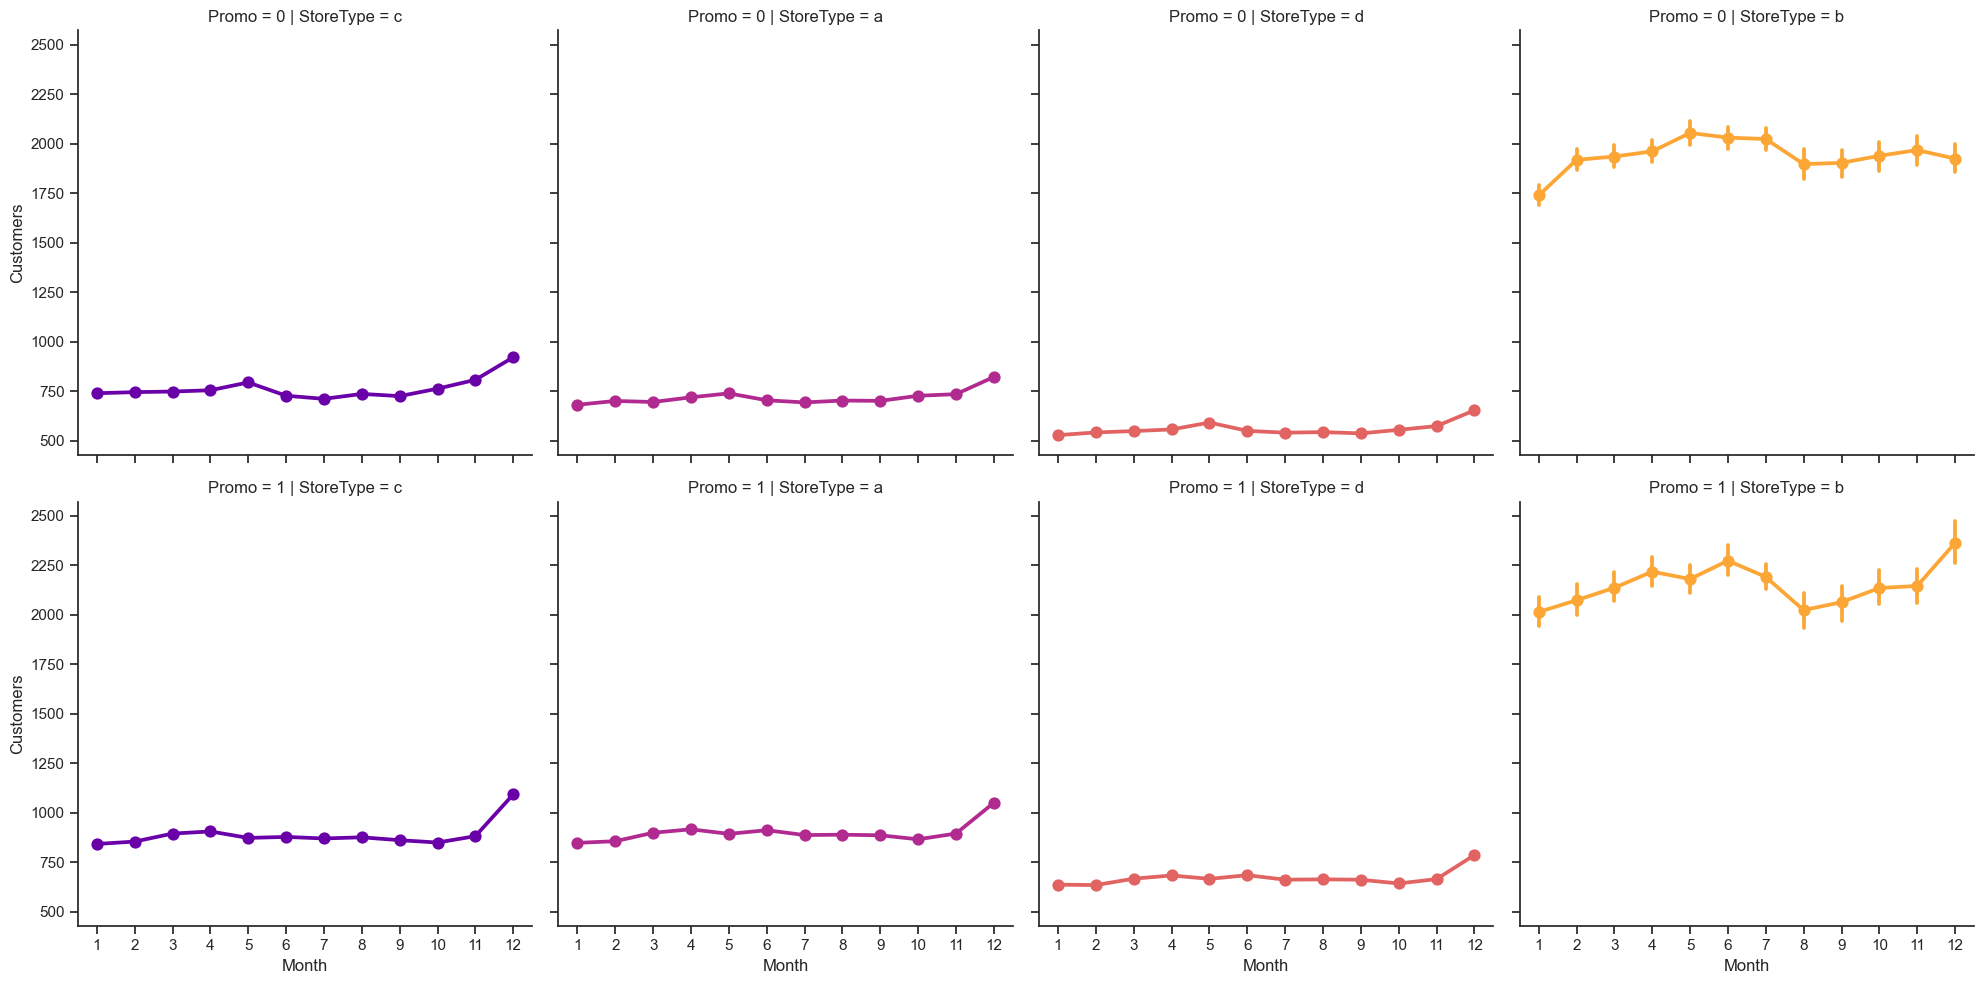

In [32]:
# Customer Trends
sns.catplot(data = train_store_df, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               kind = 'point',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 
plt.show()

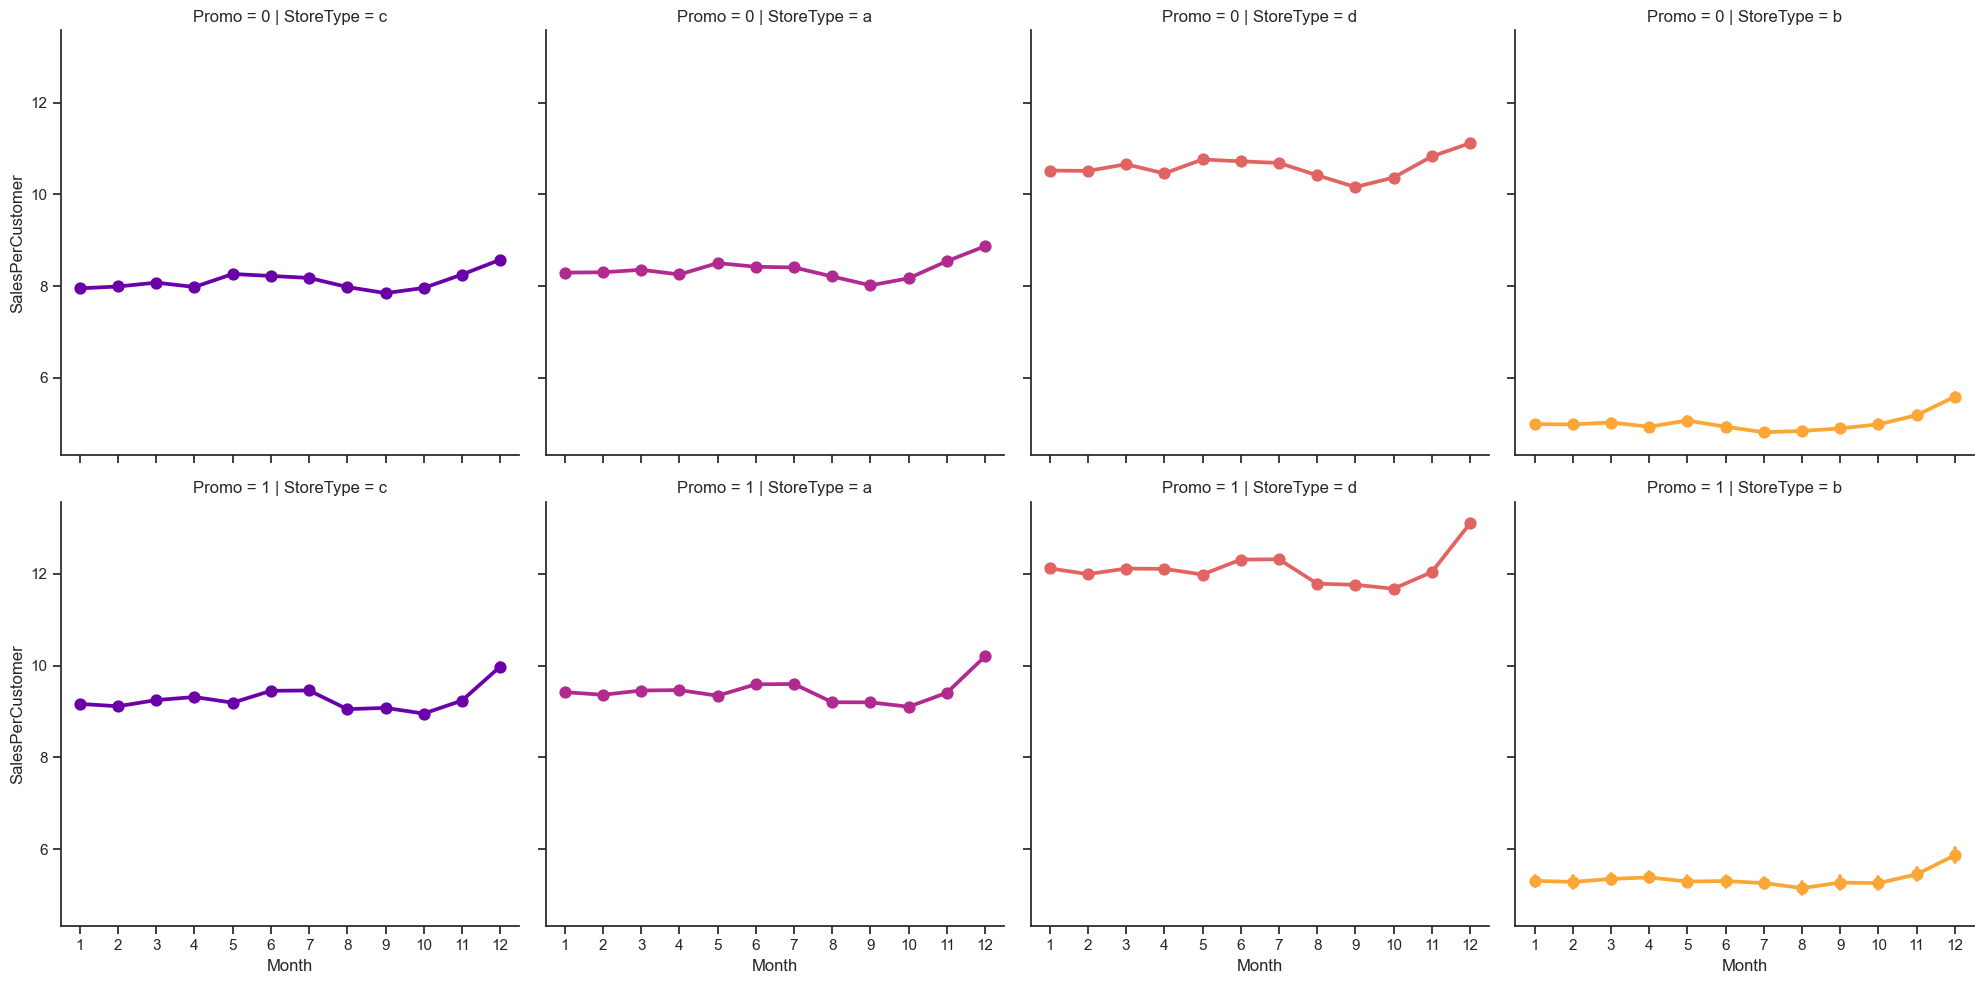

In [33]:
# sale per customer trends
sns.catplot(data = train_store_df, x = 'Month', y = "SalesPerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               kind='point',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c)
plt.show()

##### The highest SalesPerCustomer amount is observed at the StoreType D, about $12 with Promo and $10 without. For StoreType A and C it is about $9.

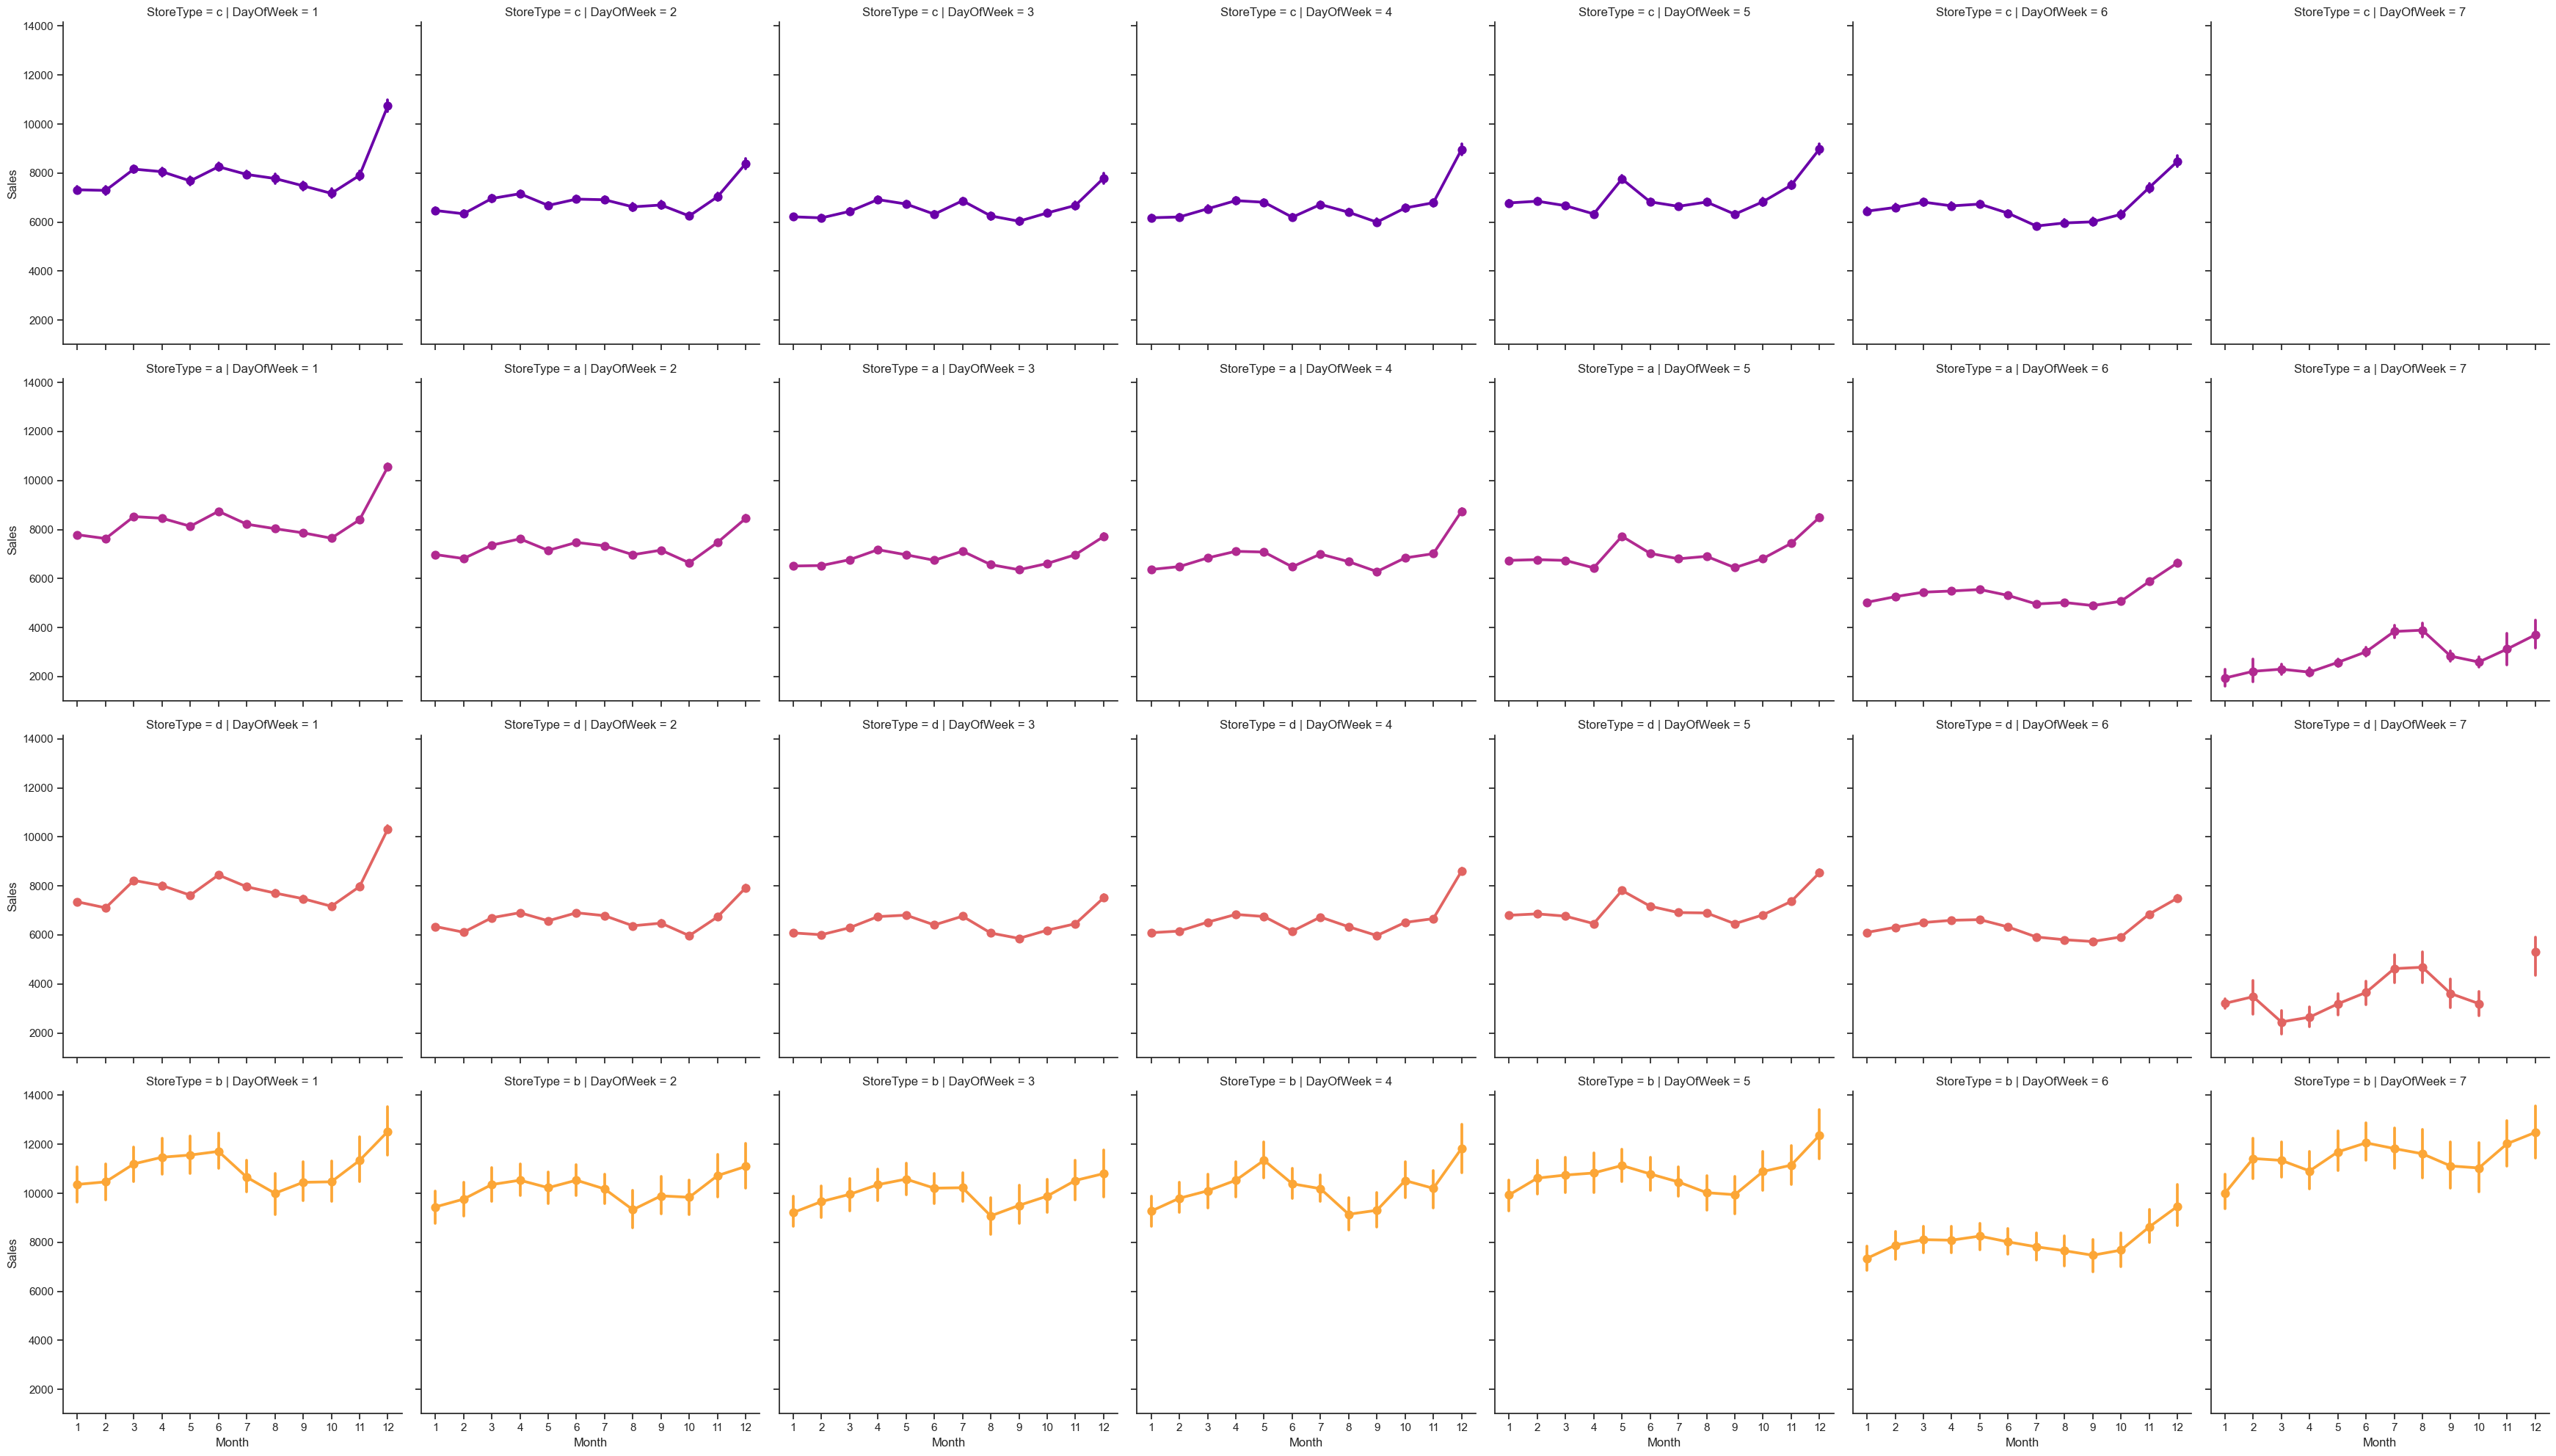

In [34]:
# Sales vs Day of Week
sns.catplot(data = train_store_df, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               kind = 'point',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c) 

plt.show()

In [35]:
# stores which are opened on Sundays
train_store_df[(train_store_df.Open == 1) & (train_store_df.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

In [36]:
# Add variables describing the period of time during which competition and promotion were opened

# competition open time (in months)
train_store_df['CompetitionOpen'] = 12 * (train_store_df.Year - train_store_df.CompetitionOpenSinceYear) + \
        (train_store_df.Month - train_store_df.CompetitionOpenSinceMonth)
    
# Promo open time
train_store_df['PromoOpen'] = 12 * (train_store_df.Year - train_store_df.Promo2SinceYear) + \
        (train_store_df.WkofYr - train_store_df.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store_df.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store_df.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


### Correlation Analysis
---

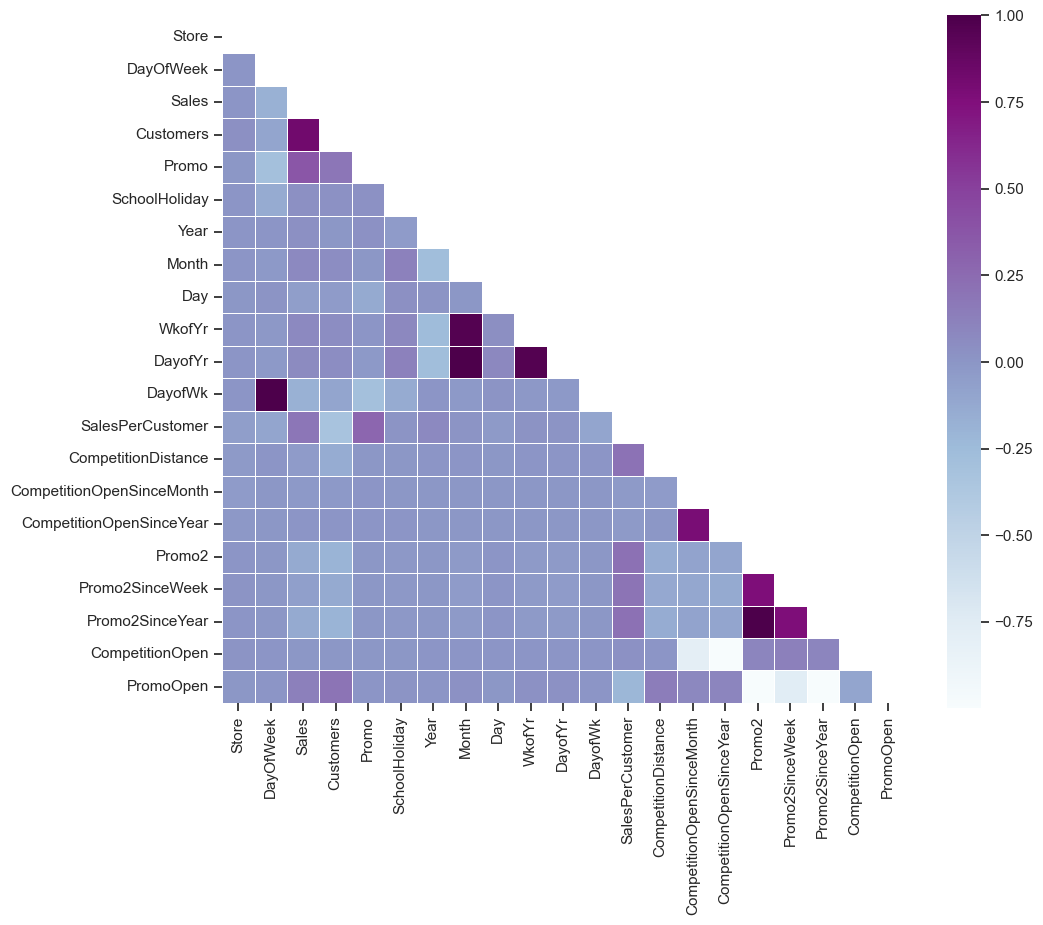

In [37]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store_df.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

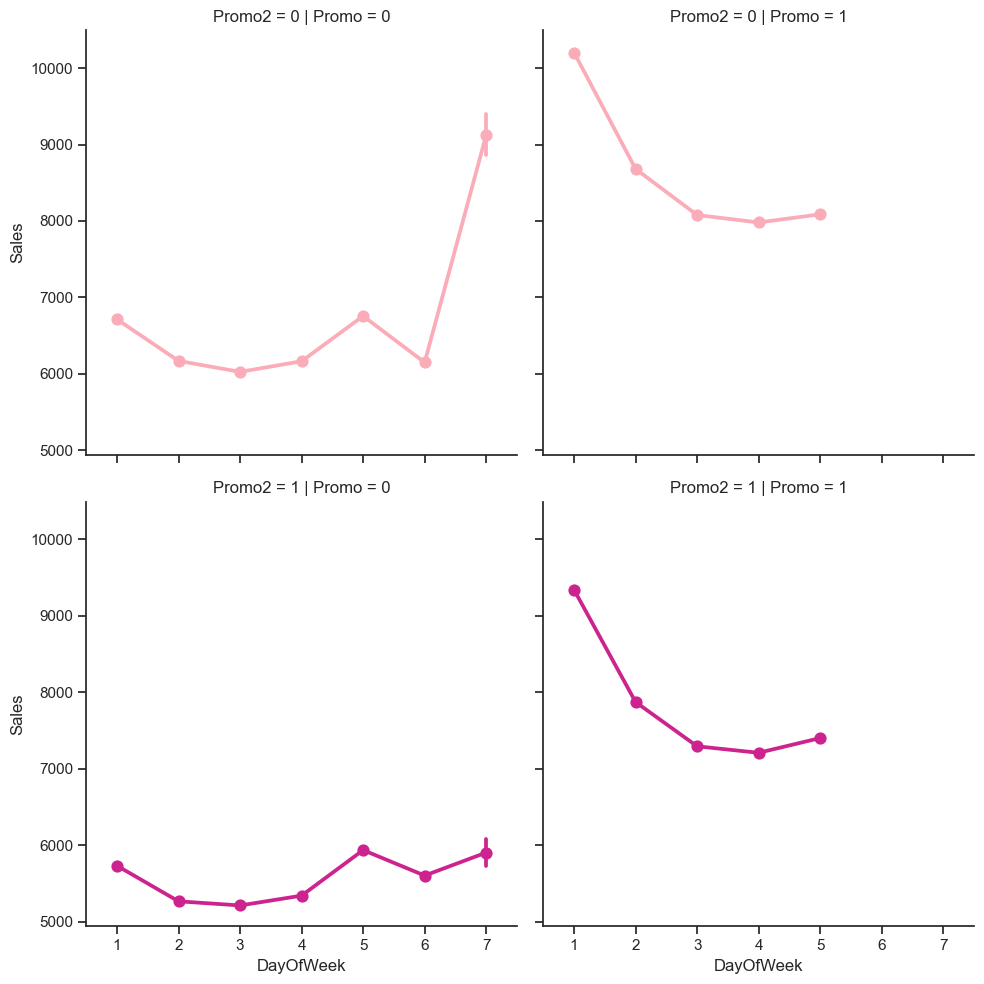

In [38]:
# sale per customer trends
sns.catplot(data = train_store_df, x = 'DayOfWeek', y = "Sales", kind='point',
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 
plt.show()